<a href="https://colab.research.google.com/github/MingyangLou/DataXMindReader/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# enhance inline image quality
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Note: I rename the folder to HMM since it's Hidden Markov Model, check folder name if this line doesn't work

In [3]:
%cd "/content/drive/My Drive/Volvo HMM Project/"

/content/drive/.shortcut-targets-by-id/1T01a1rxUdrfdS4tfGgwWks4bUw3sfNf0/Volvo HMM Project


# Load Data
Here we have several datasets 
- Pagesequences (session based)
- Timesequences (session based)
- Dictionary (map from page index to page category)
Additional datasets added later
- Pagesequences (user based)
- Timesequences (user based)

We'll perform data processing and exploratory data analysis on them in this notebook.
## Session based vs User based (Multi-session)
- Session based means we **view session individually** and it will be marked as converted only if there's at least one converting event in the sequence.
- User based means if we oberserve one converting event/action from **one user**, **all sessions** associated with that person within a certain period (e.g. 14 days) will all be marked as converted.

In [4]:
# category to index dictionary
category2IdxDict = pd.read_csv('./Datasets/category2IdxDict')
# index to category dictionary
idx2CategoryDict = pd.read_csv('./Datasets/idx2CategoryDict')

In [ ]:
display(category2IdxDict.head())

,category,idx
0,Accessories_shop,0
1,PDP_V90,1
2,Leads_xc40recharge_keep_informed,2
3,CarConfigurator_landing_r-design,3
4,Search,4


In [101]:
# Converted user sequences -  contain at least one conversion event. Note: First element is the media channel
c_pageseq = pd.read_csv('./Datasets/q4_cPageSeq.csv')
# Dwelling times for converted user sequences - Note: one element less since there is no dwelling time for the media channel
c_pageseqtimes = pd.read_csv('./Datasets/q4_cPageSeqTimes.csv')
# Non converted user sequences -  Does not contain a conversion event. 
nc_pageseq = pd.read_csv('./Datasets/q4_ncPageSeq.csv')
# Dwelling times for non - converted user sequences
nc_pageseqtimes = pd.read_csv('./Datasets/q4_ncPageSeqTimes.csv')


In [102]:
display(c_pageseq.head())
display(c_pageseqtimes.head())

,ids,seq
0,"1569880989,4591098790048594944","126,74,84,74,84,24"
1,"1569881650,8163510663962056704","125,95,84,24"
2,"1569882913,5836022827757765632","125,77,5,74,5,74,85,90,93,99,91,92,96,95,87,86..."
3,"1569883055,3586855111765427200","130,79,84,79,85,90,93,99,91,92,96,95,87,86,84,..."
4,"1569883489,906571704020631040","125,85,90,93,99,91,92,96,95,96,95,86,87,96,87,..."


,session_id,user_id,timelist,average_time,total_time,length,converted
0,1569880989,4591098790048594944,"[36.17, 8.08, 53.54, 55.54, 0.0]",30.666000,153.33,5,1
1,1569881650,8163510663962056704,"[861.66, 15.93, 0.0]",292.530000,877.59,3,1
2,1569882913,5836022827757765632,"[12.45, 32.84, 325.86, 14.4, 49.31, 55.66, 788...",88.049444,1584.89,18,1
3,1569883055,3586855111765427200,"[16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15.02...",27.797500,444.76,16,1
4,1569883489,906571704020631040,"[41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10.25,...",64.934815,1753.24,27,1


# Data Preprocessing

Clean Dictionary

In [ ]:
# category2IdxDict = category2IdxDict.drop(['Unnamed: 0'],axis=1)
# category2IdxDict.rename(columns={'0':'category', '1': 'idx'}, inplace=True)
# idx2CategoryDict = idx2CategoryDict.drop(['Unnamed: 0'], axis=1)
# idx2CategoryDict.rename(columns={'0':'idx','1':'category'}, inplace=True)

# category2IdxDict.head()

In [ ]:
# Write back cleaned data
# category2IdxDict.to_csv('./Datasets/category2IdxDict', index = False)
# idx2CategoryDict.to_csv('./Datasets/idx2CategoryDict', index = False)

Clean page sequences

In [ ]:
# The first column of pageseq dfs shoud be seesion id
# c_pageseq.rename(columns={'Unnamed: 0': "ids"}, inplace=True)
# c_pageseqtimes.rename(columns={'Unnamed: 0': "ids"}, inplace=True)
# nc_pageseq.rename(columns={'Unnamed: 0': "ids"}, inplace=True)
# nc_pageseqtimes.rename(columns={'Unnamed: 0': "ids"}, inplace=True)

In [ ]:
# Write back cleaned data
# c_pageseq.to_csv('./Datasets/q4_cPageSeq.csv', index = False)
# c_pageseqtimes.to_csv('./Datasets/q4_cPageSeqTimes.csv', index = False)
# nc_pageseq.to_csv('./Datasets/q4_ncPageSeq.csv', index = False)
# nc_pageseqtimes.to_csv('./Datasets/q4_ncPageSeqTimes.csv', index = False)

#### Converting Events
We find four pages that represent conversion events by manually inspecting.
- Submit_dealerContact
- Testdrive_submit
- CarebyVolvo_submit
- CarConfigurator_Finish

In [55]:
# Pages that represent a conversion
# c_pages = [24, 34, 39, 86]
c_pages = [24, 34, 39]
def get_category(idx):
    return category2IdxDict["category"][idx]

def find_conversions(seqlist): 
    return [get_category(x) for x in set(seqlist).intersection(set(c_pages))]

find_conversions(c_pages)

['Submit_dealerContact', 'Testdrive_submit', 'CarebyVolvo_submit']

In [139]:
def page_preprocess(df):
  # Convert seqeunce string to a list
  df['seqlist'] = df['seq'].apply(lambda x: [int(i) for i in x.split(",")])
  # Media is the first element of the sequence
  df['media'] = df.seqlist.apply(lambda x: get_category(x[0]))
  # Page at leave
  df['end'] = df.seqlist.apply(lambda x: x[-1])
  df["end_category"] = df["end"].apply(get_category)
  # Split ids to session id and user id if ids hasn't been cleaned yet
  if 'ids' in df.columns:
    df['session_id'] = df.ids.apply(lambda x: x.split(',')[0])
    df['user_id'] = df.ids.apply(lambda x: x.split(',')[1])
    df = df.drop('ids', axis =1)
  # Converting pages in the sequence
  df['c_pages'] = df.seqlist.apply(find_conversions)
  # Number of converting pages in the sequence
  df['c_actions'] = df['c_pages'].apply(len)
  df = df.drop('seq', axis =1)
  # Number of configurator page visits
  df["configs"] = df["seqlist"].apply(lambda x: x.count(86))
  return df

In [104]:
c_pageseq = page_preprocess(c_pageseq)
nc_pageseq = page_preprocess(nc_pageseq)
display(c_pageseq.head())
display(nc_pageseq.head())

,seqlist,media,end,end_category,session_id,user_id,c_pages,c_actions,configs
0,"[126, 74, 84, 74, 84, 24]",cpc,24,Submit_dealerContact,1569880989,4591098790048594944,[Submit_dealerContact],1,0
1,"[125, 95, 84, 24]",organic,24,Submit_dealerContact,1569881650,8163510663962056704,[Submit_dealerContact],1,0
2,"[125, 77, 5, 74, 5, 74, 85, 90, 93, 99, 91, 92...",organic,24,Submit_dealerContact,1569882913,5836022827757765632,[Submit_dealerContact],1,1
3,"[130, 79, 84, 79, 85, 90, 93, 99, 91, 92, 96, ...",social,77,HomePage,1569883055,3586855111765427200,[Submit_dealerContact],1,1
4,"[125, 85, 90, 93, 99, 91, 92, 96, 95, 96, 95, ...",organic,84,Leads_getLocalPrice,1569883489,906571704020631040,[Submit_dealerContact],1,2


,seqlist,media,end,end_category,session_id,user_id,c_pages,c_actions,configs
0,"[125, 37]",organic,37,AboutVolvo_stories,1569876967,1308456419587147520,[],0,0
1,"[194, 74, 85, 90, 87, 86]",siteserved,86,CarConfigurator_Finish,1569878305,1047422600987439360,[],0,1
2,"[127, 95]",(none),95,CarConfigurator_optionalEquipment,1569878470,52179069622710728,[],0,0
3,"[125, 91, 92, 96, 95, 91, 99, 90, 99, 91, 92, ...",organic,90,CarConfigurator_colorSelection,1569878589,3002711543435918336,[],0,1
4,"[126, 99, 91, 92, 96, 95, 87, 95, 90, 93, 91, ...",cpc,87,CarConfigurator_summary,1569878652,4908817402337326080,[],0,1


Clean time sequences

In [32]:
c_pageseqtimes.head()

,ids,seq
0,"1569880989,4591098790048594944","[36.17, 8.08, 53.54, 55.54, 0.0]"
1,"1569881650,8163510663962056704","[861.66, 15.93, 0.0]"
2,"1569882913,5836022827757765632","[12.45, 32.84, 325.86, 14.4, 49.31, 55.66, 788..."
3,"1569883055,3586855111765427200","[16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15.02..."
4,"1569883489,906571704020631040","[41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10.25,..."


In [ ]:
# Converted customers
c_pageseqtimes['total_time'] = c_pageseqtimes.seq.apply(lambda x: sum(list(map(float, x[1:-1].split(',')))))
c_pageseqtimes['average_time'] = c_pageseqtimes.seq.apply(lambda x: np.mean(list(map(float, x[1:-1].split(',')))))
c_pageseqtimes['seq_length'] = c_pageseqtimes.seq.apply(lambda x: len(x[1:-1].split(',')))
c_pageseqtimes['converted'] = 1

# Non converted customers
nc_pageseqtimes['total_time'] = nc_pageseqtimes.seq.apply(lambda x: sum(list(map(float, x[1:-1].split(',')))))
nc_pageseqtimes['average_time'] = nc_pageseqtimes.seq.apply(lambda x: np.mean(list(map(float, x[1:-1].split(',')))))
nc_pageseqtimes['seq_length'] = nc_pageseqtimes.seq.apply(lambda x: len(x[1:-1].split(',')))
nc_pageseqtimes['converted'] = 0



In [59]:
def time_preprocess(df):
  # Split ids to session id and user id
  df['session_id'] = df.ids.apply(lambda x: x.split(',')[0])
  df['user_id'] = df.ids.apply(lambda x: x.split(',')[1])

  df['timelist'] = df.seq.apply(lambda x: list(map(float, x[1:-1].split(','))))
  # average dwelling time per page in a session
  df['average_time'] = df.timelist.apply(np.mean)
  # the total dwelling time for a session
  df['total_time'] = df.timelist.apply(sum)
  # length of time sequence
  df['length'] = df.timelist.apply(len)
  df = df.drop(['ids', 'seq'], axis =1)
  return df

In [60]:
c_pageseqtimes = time_preprocess(c_pageseqtimes)
nc_pageseqtimes = time_preprocess(nc_pageseqtimes)
display(c_pageseqtimes.head())
display(nc_pageseqtimes.head())

,session_id,user_id,timelist,average_time,total_time,length
0,1569880989,4591098790048594944,"[36.17, 8.08, 53.54, 55.54, 0.0]",30.666000,153.33,5
1,1569881650,8163510663962056704,"[861.66, 15.93, 0.0]",292.530000,877.59,3
2,1569882913,5836022827757765632,"[12.45, 32.84, 325.86, 14.4, 49.31, 55.66, 788...",88.049444,1584.89,18
3,1569883055,3586855111765427200,"[16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15.02...",27.797500,444.76,16
4,1569883489,906571704020631040,"[41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10.25,...",64.934815,1753.24,27


,session_id,user_id,timelist,average_time,total_time,length
0,1569876967,1308456419587147520,[824.53],824.530000,824.53,1
1,1569878305,1047422600987439360,"[32.76, 174.22, 36.29, 0.3, 0.0]",48.714000,243.57,5
2,1569878470,52179069622710728,[51.06],51.060000,51.06,1
3,1569878589,3002711543435918336,"[5.83, 6.64, 9.71, 41.92, 14.35, 1.24, 22.99, ...",11.876667,178.15,15
4,1569878652,4908817402337326080,"[57.68, 18.27, 9.06, 77.73, 105.2, 0.24, 5.99,...",44.111765,749.90,17


Combines converted and non-converted page sequences.

In [105]:
c_pageseq['converted'] = 1
nc_pageseq['converted'] = 0
all_pageseq = pd.concat([c_pageseq, nc_pageseq], ignore_index=True)

In [106]:
all_pageseq.head()

,seqlist,media,end,end_category,session_id,user_id,c_pages,c_actions,configs,converted
0,"[126, 74, 84, 74, 84, 24]",cpc,24,Submit_dealerContact,1569880989,4591098790048594944,[Submit_dealerContact],1,0,1
1,"[125, 95, 84, 24]",organic,24,Submit_dealerContact,1569881650,8163510663962056704,[Submit_dealerContact],1,0,1
2,"[125, 77, 5, 74, 5, 74, 85, 90, 93, 99, 91, 92...",organic,24,Submit_dealerContact,1569882913,5836022827757765632,[Submit_dealerContact],1,1,1
3,"[130, 79, 84, 79, 85, 90, 93, 99, 91, 92, 96, ...",social,77,HomePage,1569883055,3586855111765427200,[Submit_dealerContact],1,1,1
4,"[125, 85, 90, 93, 99, 91, 92, 96, 95, 96, 95, ...",organic,84,Leads_getLocalPrice,1569883489,906571704020631040,[Submit_dealerContact],1,2,1


Combine converted and non-converted time sequences

In [64]:
c_pageseqtimes['converted'] = 1
nc_pageseqtimes['converted'] = 0

In [65]:
all_pageseqtimes = pd.concat([c_pageseqtimes, nc_pageseqtimes], ignore_index=True)

In [66]:
all_pageseqtimes.head()

,session_id,user_id,timelist,average_time,total_time,length,converted
0,1569880989,4591098790048594944,"[36.17, 8.08, 53.54, 55.54, 0.0]",30.666000,153.33,5,1
1,1569881650,8163510663962056704,"[861.66, 15.93, 0.0]",292.530000,877.59,3,1
2,1569882913,5836022827757765632,"[12.45, 32.84, 325.86, 14.4, 49.31, 55.66, 788...",88.049444,1584.89,18,1
3,1569883055,3586855111765427200,"[16.87, 4.74, 25.1, 90.57, 12.48, 59.36, 15.02...",27.797500,444.76,16,1
4,1569883489,906571704020631040,"[41.22, 38.56, 46.11, 20.3, 4.28, 13.7, 10.25,...",64.934815,1753.24,27,1


# Exploratory Data Analysis

## Single Session Behavior

### Dwelling Times

#### Distribution per session
Total dwelling time for converted sessions

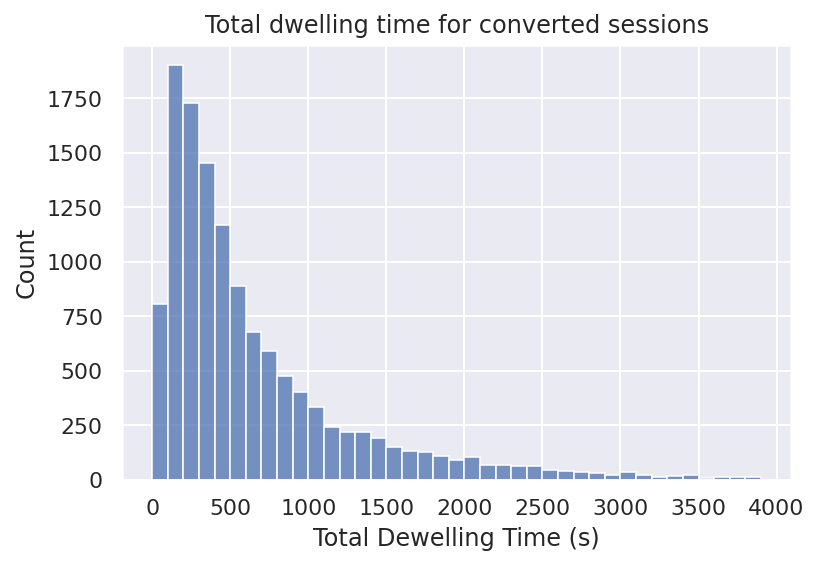

In [73]:
ax = sns.histplot(c_pageseqtimes['total_time'], bins=np.arange(0,4000,100)).set(xlabel = "Total Dewelling Time (s)")
plt.title('Total dwelling time for converted sessions');

Total dwelling time for non-converted customers

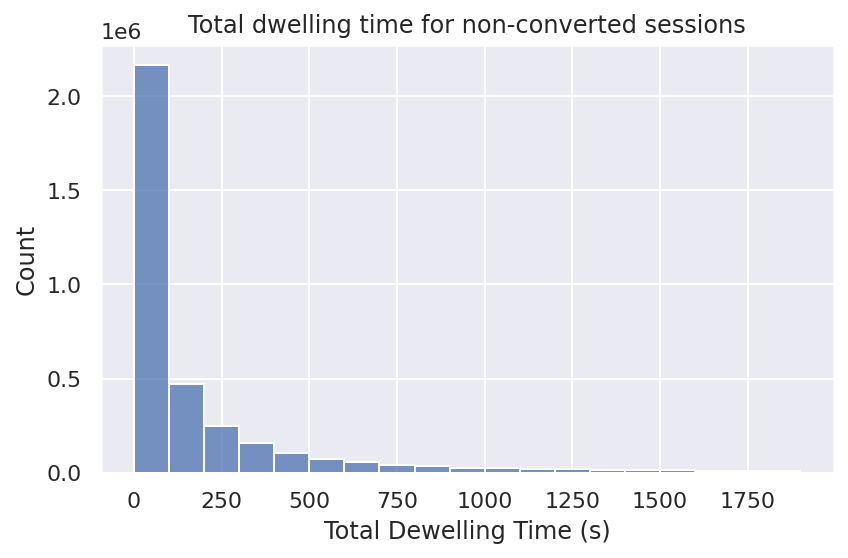

In [72]:
sns.histplot(nc_pageseqtimes['total_time'], bins=np.arange(0,2000,100)).set(xlabel = "Total Dewelling Time (s)");
plt.title('Total dwelling time for non-converted sessions');
plt.tight_layout();

Average dwelling time for converted customers

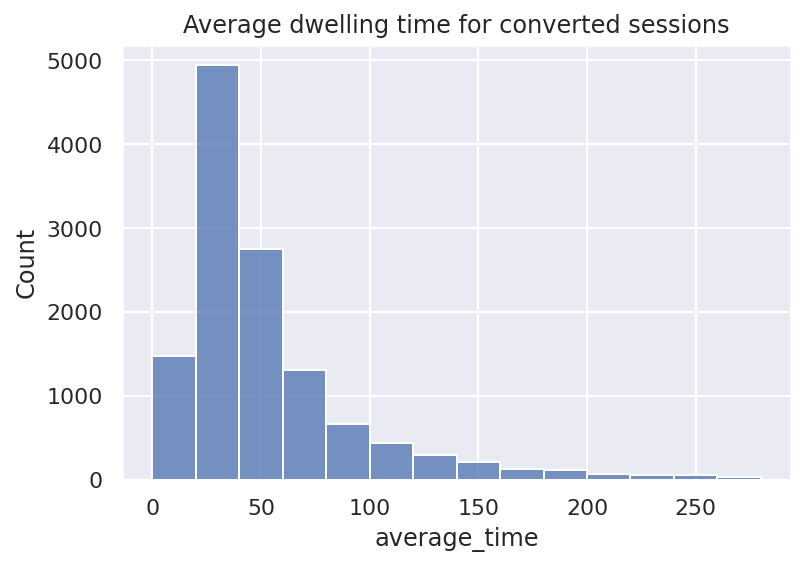

In [75]:
sns.histplot(c_pageseqtimes['average_time'], bins = np.arange(0, 300, 20))
plt.title('Average dwelling time for converted sessions');

Average dwelling time for non-converted customers

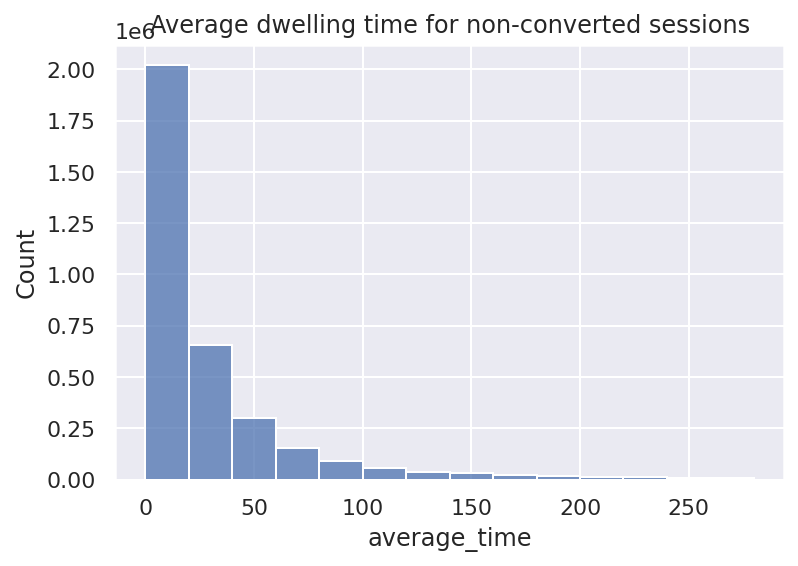

In [76]:
sns.histplot(nc_pageseqtimes['average_time'], bins = np.arange(0, 300, 20))
plt.title('Average dwelling time for non-converted sessions');

#### Distribution per page

In [78]:
all_times = all_pageseqtimes["timelist"].explode("timelist")
retained_times = all_times.where(all_times > 1)
display(retained_times.agg(["mean", "std", "min", "median", "max"]))

mean         57.852618
std         159.635781
min           1.010000
median       19.360000
max       33891.400000
Name: timelist, dtype: float64

Distribution of page dwelling times between 1 second and 1 minute.

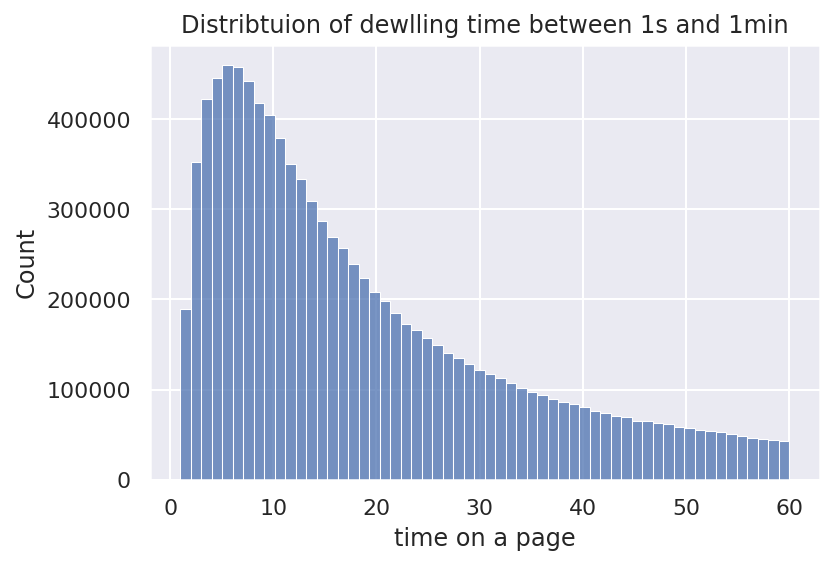

In [80]:
sns.histplot(all_times, bins = np.linspace(1, 60, num = 59));
plt.title('Distribtuion of dewlling time between 1s and 1min');
plt.xlabel('time on a page');

Distribution of page dwelling times under 1 second.



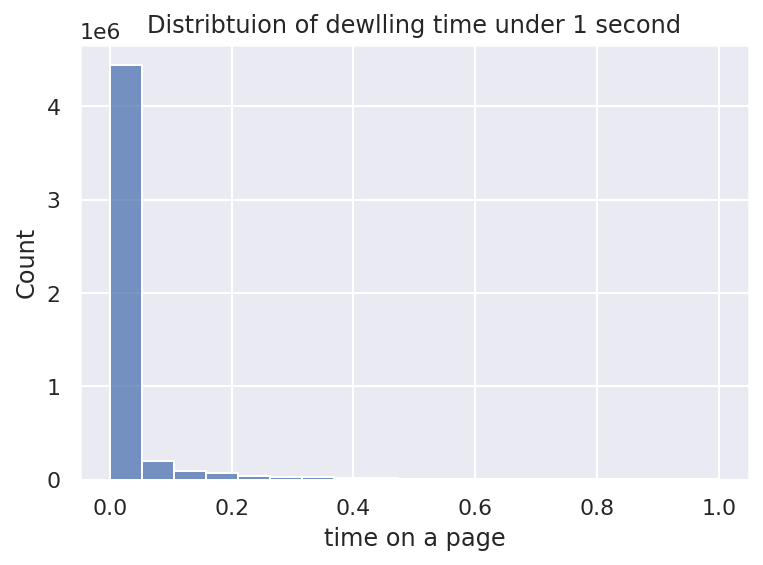

In [81]:
sns.histplot(all_times, bins = np.linspace(0, 1, num = 20));
plt.title('Distribtuion of dewlling time under 1 second');
plt.xlabel('time on a page');

Distribution of page dwelling times over 1 minute.

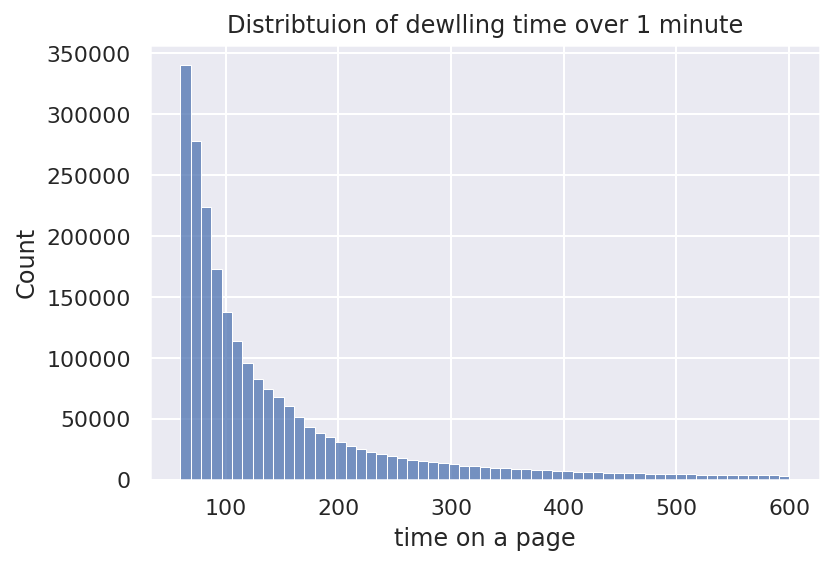

In [83]:
sns.histplot(all_times[all_times >= 60], bins = np.linspace(60, 600, num = 60));
plt.title('Distribtuion of dewlling time over 1 minute');
plt.xlabel('time on a page');

#### Sequence Lengths

Seq length for converted sessions

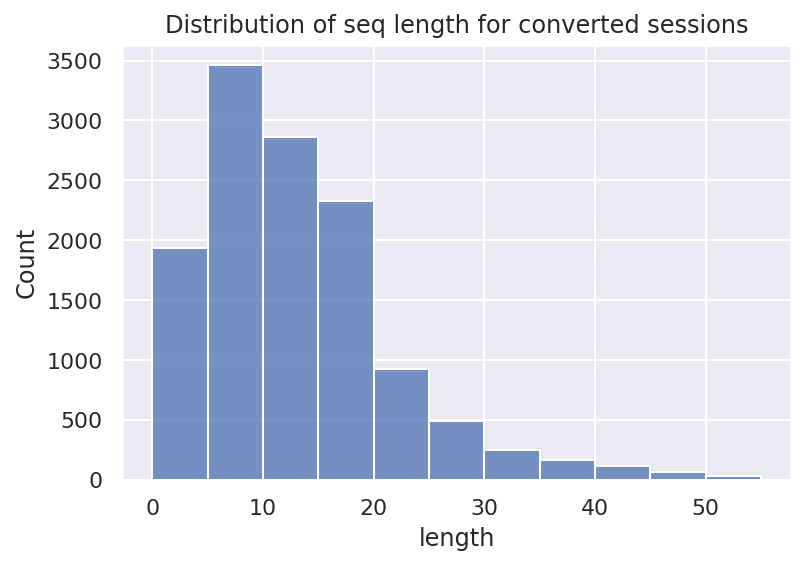

In [88]:
sns.histplot(c_pageseqtimes['length'], bins = np.arange(0, 60, 5))
plt.title('Distribution of seq length for converted sessions');

Seq length for non-converted sessions

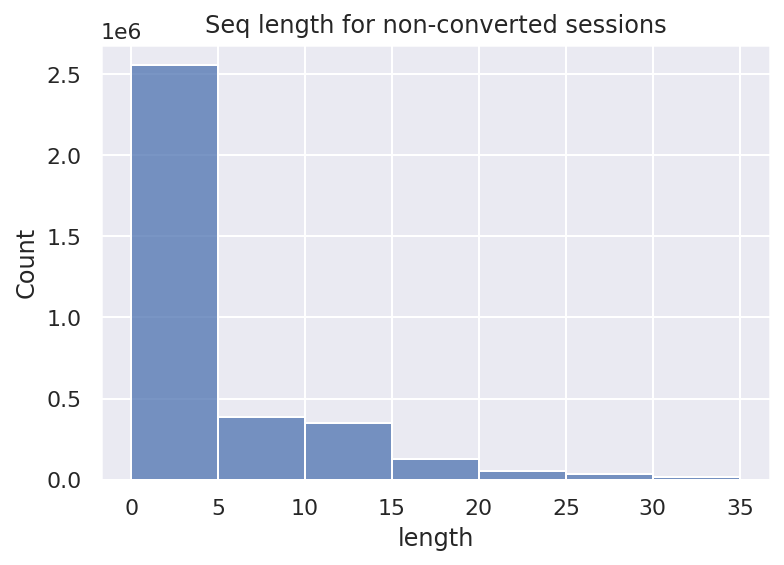

In [89]:
sns.histplot(nc_pageseqtimes['length'], bins = np.arange(0, 40, 5))
plt.title('Seq length for non-converted sessions');

### Conversion Rates

#### Overall Conversion Rate

In [90]:
print(f"The overall conversion rate is {all_pageseqtimes.converted.mean()*100:.2f}%")

The overall conversion rate is 0.36%


#### Conversion Rate by Visit Sequence Length

In [93]:
# Average sequence length is 5
all_pageseqtimes.length.mean()

4.922289666120359

In [91]:
print(f"The converstion rate in customers who visited less than 5 pages is \
{all_pageseqtimes[all_pageseqtimes.length < 5].converted.mean() * 100:.2f}%.")

print(f"The converstion rate in customers who visited more than 5 pages is \
{all_pageseqtimes[all_pageseqtimes.length >=5].converted.mean() * 100:.2f}%.")


The converstion rate in customers who visited less than 5 pages is 0.08%.
The converstion rate in customers who visited more than 5 pages is 1.08%.


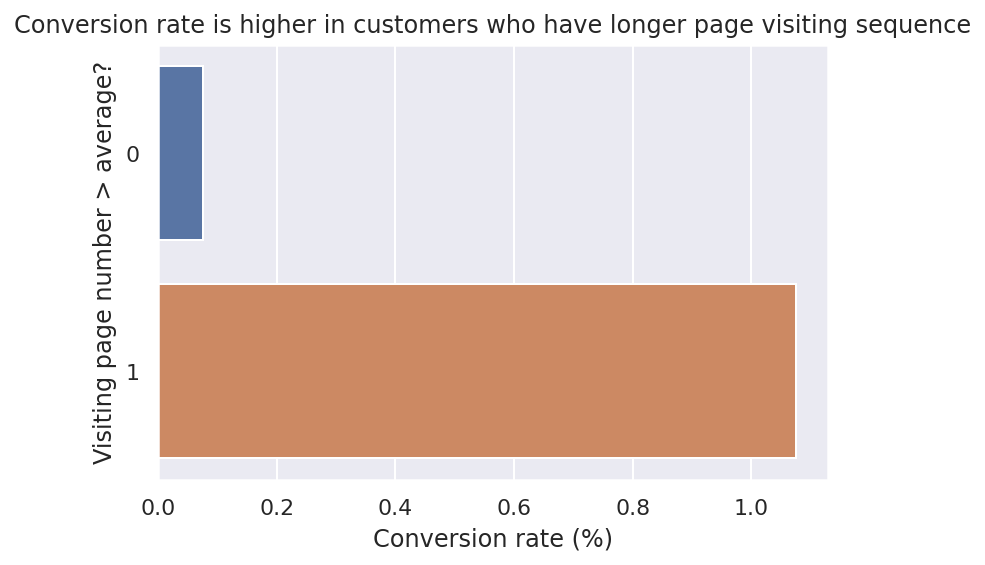

In [92]:
sns.barplot(y = [0,1],\
            x = [all_pageseqtimes[all_pageseqtimes.length < 5].converted.mean() * 100, \
             all_pageseqtimes[all_pageseqtimes.length >= 5].converted.mean() * 100], orient = 'h')
plt.title("Conversion rate is higher in customers who have longer page visiting sequence")
plt.ylabel('Visiting page number > average?')
plt.xlabel('Conversion rate (%)');

In [ ]:
all_pageseqtimes.groupby('converted').converted.mean()

converted
0    0
1    1
Name: converted, dtype: int64

#### Conversion Rate by Media Channel

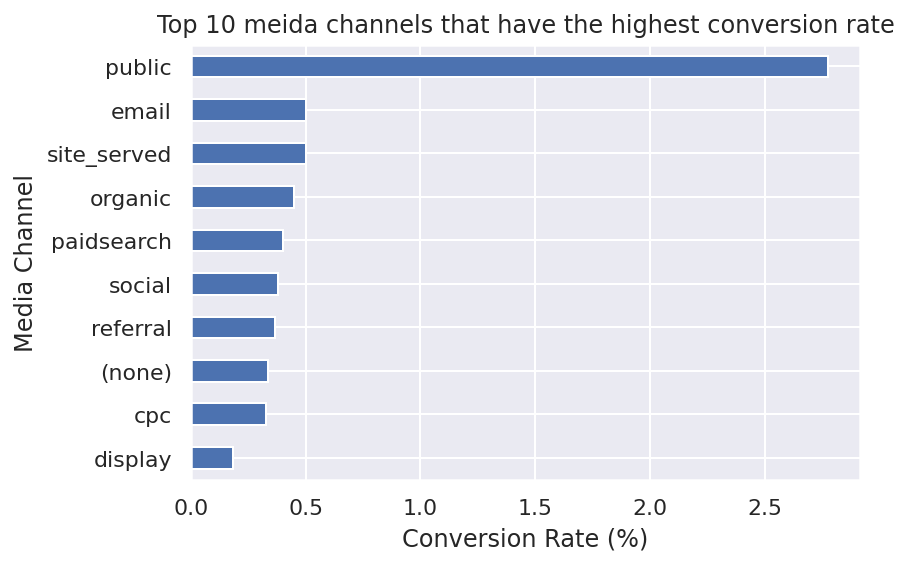

In [111]:
(all_pageseq.groupby('media').converted.mean().sort_values()*100)[-10:].plot(kind='barh')
plt.title('Top 10 meida channels that have the highest conversion rate')
plt.ylabel('Media Channel')
plt.xlabel('Conversion Rate (%)');
#plt.xticks(rotation = 60);

### Building a Car

Out of the converted visitors that built a vehicle, most are focused on a single model. 

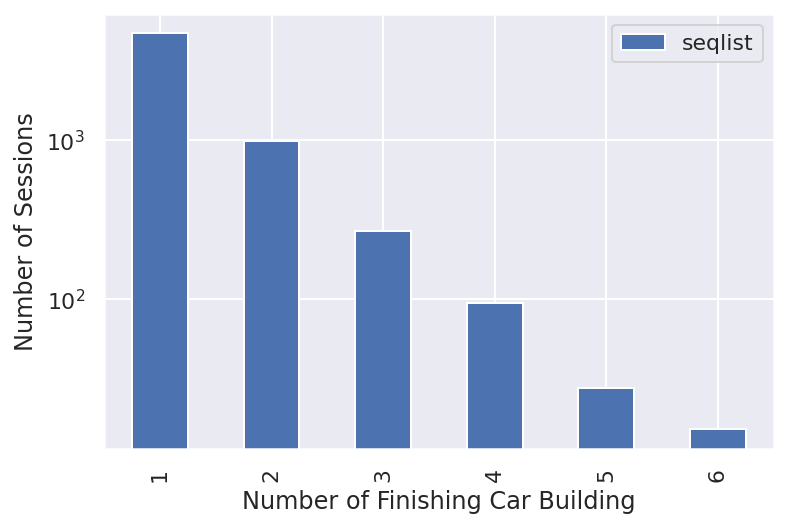

In [109]:
c_pageseq[c_pageseq["configs"] != 0].groupby("configs").count()[:6].plot(kind = "bar", y = "seqlist");
plt.yscale("log")
plt.xlabel('Number of Finishing Car Building')
plt.ylabel('Number of Sessions');

### Number of Conversion events

When looking at all conversion actions however, most converted visitors engage in one conversion action.

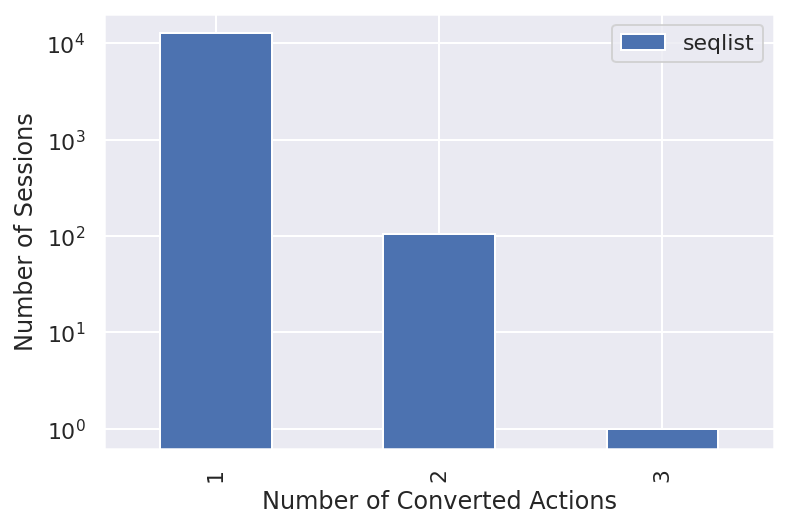

In [100]:
c_pageseq.groupby("c_actions").count()[:3].plot(kind = "bar", y = "seqlist");
plt.yscale("log")
plt.xlabel('Number of Converted Actions');
plt.ylabel('Number of Sessions');

### Drop-offs

For visitors who have already converted, the biggest dropoff pages are below.

In [119]:
c_dropoffs = c_pageseq[~c_pageseq["end"].isin(c_pages)].groupby("end_category").count().sort_values("seqlist", ascending = False).reset_index()[["end_category", "seqlist"]]
c_dropoffs.rename({'seqlist':'number'}, axis =1, inplace= True)
c_dropoffs.head(10)

,end_category,number
0,ShoppingTools_offers_overviewPage,1847
1,CarebyVolvo_checkout_insurance,1176
2,Leads_getLocalPrice,960
3,CarConfigurator_Finish,667
4,HomePage,609
5,CarebyVolvo_checkout_credit,535
6,CarConfigurator_optionalEquipment,378
7,Leads_testDrive,255
8,CarConfigurator_Start,198
9,ShoppingTools_newInventorysearch,182


For visitors who did not convert, the biggest dropoff pages are below. 

- Most non-converters actually finished carconfigurator but didn't proceed to contact dealer or lease a car.
- We can also see some models such as XC90 and S60 are popular.

In [121]:
nc_dropoffs = nc_pageseq.groupby("end_category").count().sort_values("seqlist", ascending = False).reset_index()[["end_category", "seqlist"]]
# nc_dropoffs[~nc_dropoffs["end_category"].str.contains("PDP")].head(10)
nc_dropoffs.rename({'seqlist':'number'}, axis =1, inplace= True)
nc_dropoffs.head(10)

,end_category,number
0,CarConfigurator_Finish,367655
1,PDP_XC90,346187
2,CarConfigurator_Start,345175
3,HomePage,225154
4,ShoppingTools_offers_overviewPage,193826
5,PDP_S60,170637
6,PDP_XC40,170403
7,PDP_XC60,163560
8,CarConfigurator_optionalEquipment,159269
9,PDP_XC40Recharge,123435


## User / Multi-Session Behavior

In [128]:
c_user_pageseq = pd.read_csv('./Datasets/userConvDataset/cPageSeq.csv')
nc_user_pageseq = pd.read_csv('./Datasets/userConvDataset/ncPageSeq.csv')
c_user_timeseq = pd.read_csv('./Datasets/userConvDataset/cPageSeqTimes.csv')
nc_user_timeseq = pd.read_csv('./Datasets/userConvDataset/ncPageSeqTimes.csv')

In [140]:
c_user_pageseq = page_preprocess(c_user_pageseq)
nc_user_pageseq = page_preprocess(nc_user_pageseq)

In [141]:
c_user_pageseq.head()

,session_id,user_id,seqlist,media,end,end_category,c_pages,c_actions,configs
0,1569879536,8937500239255430144,"[127, 85]",(none),85,CarConfigurator_Start,[],0,0
1,1569880343,8855731371987012608,"[125, 93, 99, 91, 92, 96]",organic,96,CarConfigurator_packagesSelection,[],0,0
2,1569880411,8201466449597986816,"[126, 31, 36]",cpc,36,CarebyVolvo_checkout_credit,[],0,0
3,1569880989,4591098790048594944,"[126, 74, 84, 74, 84, 24]",cpc,24,Submit_dealerContact,[Submit_dealerContact],1,0
4,1569881388,4436225310190582272,"[125, 80, 85, 90, 93, 99, 91, 92, 96, 95]",organic,95,CarConfigurator_optionalEquipment,[],0,0


Distribution of sessions per visitor for those who end up converting or have already converted.

### Converters
Number of sessions for conveted users.

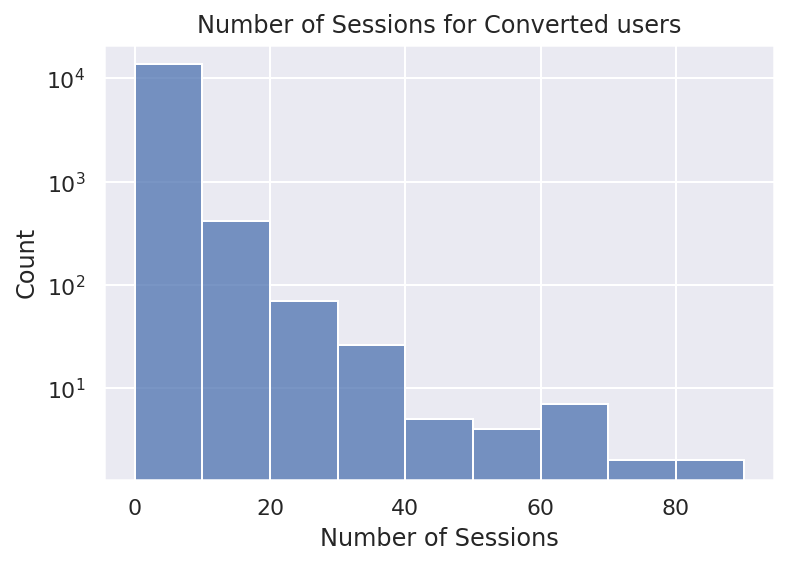

In [136]:
sns.histplot(c_user_pageseq.groupby('user_id').count()['seqlist'], bins = np.arange(0, 100,10));
plt.yscale("log")
plt.xlabel("Number of Sessions")
plt.title('Number of Sessions for Converted users');

Number of converting sessions for conveted users.

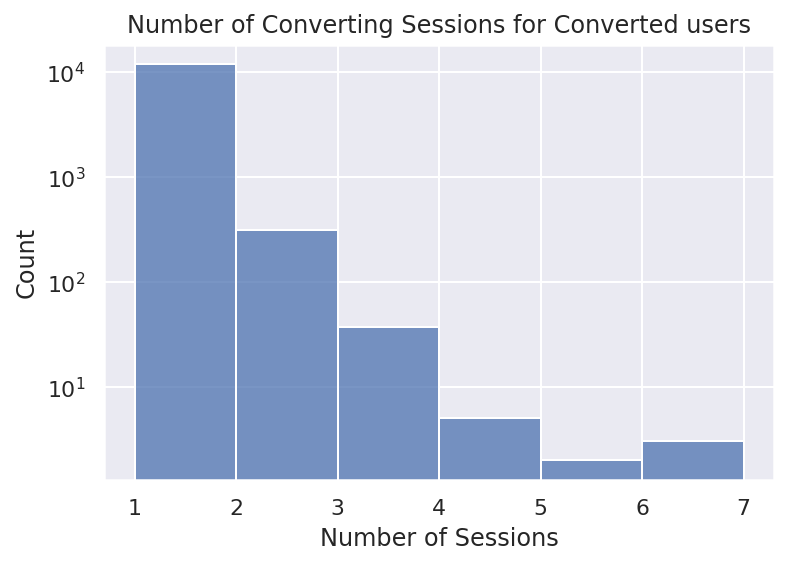

In [144]:
sns.histplot(c_user_pageseq[c_user_pageseq.c_actions>0].groupby('user_id').count()['seqlist'], bins = np.arange(1,8,1));
plt.yscale("log")
plt.xlabel("Number of Sessions")
plt.title('Number of Converting Sessions for Converted users');

Total sequence length (combining all sessions for a user) for converted users

In [150]:
c_user_grouped = c_user_pageseq.groupby('user_id')
def convert_rate(s):
  convert = len(s[s.c_actions > 0])
  return convert/len(s)

user_id
958397756782692        1.000000
1312272996312896       0.083333
1338416461369461       1.000000
1450536578581779       0.100000
1764941077057173       0.500000
                         ...   
9218221118511462400    1.000000
9218820902101411840    0.200000
9220738227043739648    0.333333
9221335064286531584    0.500000
9221351153239783424    0.500000
Length: 14174, dtype: float64

In [151]:
convert_rate_user = c_user_grouped.apply(convert_rate)

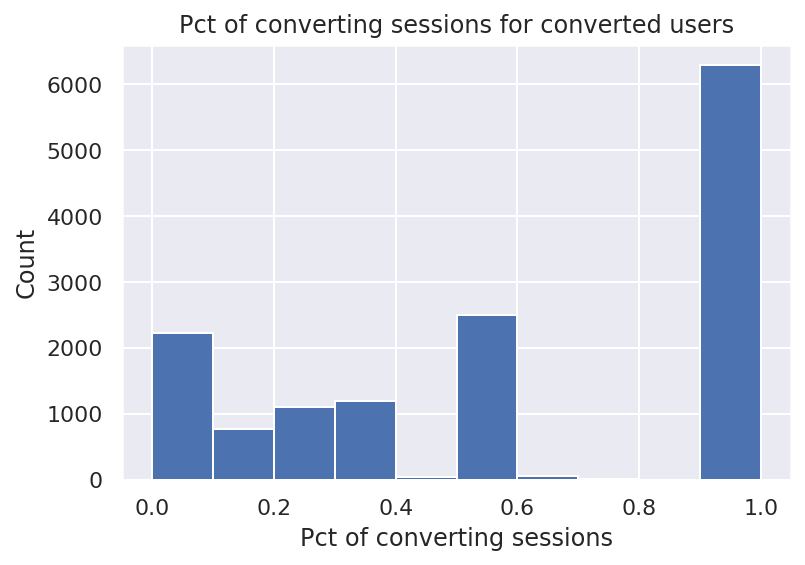

In [155]:
convert_rate_user.hist();
plt.xlabel('Pct of converting sessions')
plt.ylabel('Count')
plt.title("Pct of converting sessions for converted users");

### Non-converters

Distribution of sessions per visitor for those who don't end up converting.

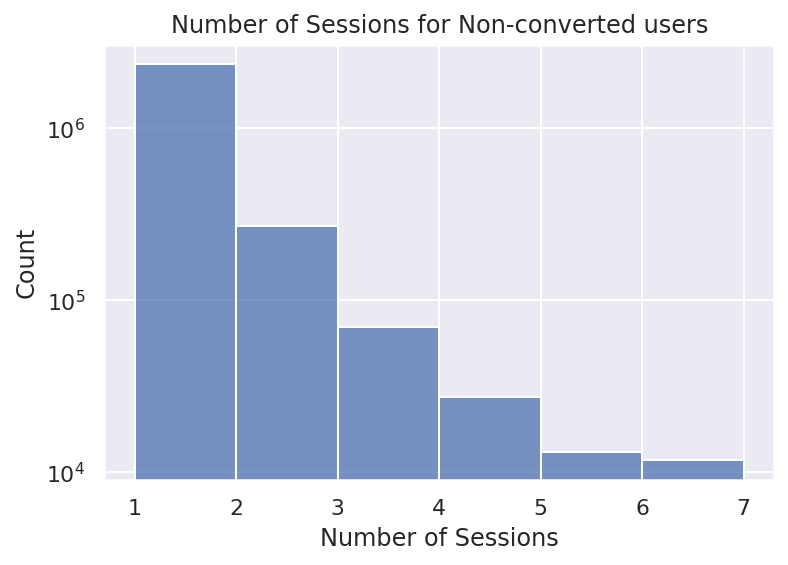

In [147]:
sns.histplot(nc_user_pageseq.groupby('user_id').count()['seqlist'], bins = np.arange(1, 8));
plt.yscale("log")
plt.xlabel("Number of Sessions")
plt.title('Number of Sessions for Non-converted users');

Number of non-converted visitors.

In [148]:
len(nc_user_pageseq.groupby('user_id'))

2732945

# Dwelling Time Distribution Per Category

*Load* category-time pairs for all sessions

In [ ]:
import pickle
with open('./Datasets/all_pairs', 'rb') as fp:
    timepairs = pickle.load(fp)

In [ ]:
import collections
o = collections.OrderedDict()

for x in timepairs:
    o.setdefault(x[0], []).append(x[1])  

In [ ]:
category2time = page_dict.copy()
#not all categories are visited, for example, media channels
category2time['timelist'] = category2time['idx'].apply(lambda x: o.get(x) if x in o.keys() else [])

In [ ]:
category2time.head()

,category,idx,gen_cat,gen_idx,timelist
0,Accessories_shop,0,Accessories_shop,2,"[49.63, 34.0, 41.22, 0.01, 711.56, 19.86, 324...."
1,PDP_V90,1,PDP,31,"[32.05, 5.42, 58.91, 747.87, 5.02, 5.44, 94.79..."
2,Leads_xc40recharge_keep_informed,2,Leads_xc40recharge_keep_informed,26,"[3.43, 26.56, 13.81, 18.79, 45.37, 8.94, 19.07..."
3,CarConfigurator_landing_r-design,3,CarConfigurator_landing,5,"[0.02, 14.46, 0.02, 0.01, 0.0, 0.0, 0.01, 16.2..."
4,Search,4,Search,32,"[57.9, 37.78, 22.04, 2.59, 0.0, 28.87, 10.24, ..."


Concatnate all timelists in each general category

In [ ]:
groupedtime = category2time.groupby('gen_idx').agg({'timelist': 'sum'})

In [ ]:
groupedtime['median'] = groupedtime['timelist'].apply(lambda x: np.median(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
groupedtime.reset_index(inplace=True)
groupedtime.head()

,gen_idx,timelist,median
0,0,"[17.02, 9.66, 93.96, 58.65, 7.19, 258.87, 43.9...",19.91
1,1,"[0.07, 0.0, 0.01, 0.01, 0.02, 0.0, 0.0, 176.87...",0.02
2,2,"[49.63, 34.0, 41.22, 0.01, 711.56, 19.86, 324....",0.01
3,3,"[0.68, 9.67, 0.15, 0.0, 3.43, 39.16, 41.05, 0....",0.01
4,4,"[6.48, 26.41, 2.68, 5.28, 80.14, 23.95, 8.02, ...",11.64


In [ ]:
groupedtime['cnt_immleave'] = groupedtime.timelist.apply(lambda x : sum(np.array(x) <= 1))

In [ ]:
groupedtime['median_without_immleave'] = groupedtime.timelist.apply(lambda x : np.median(np.array(x)[np.array(x)>1]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
groupedtime.head()

,gen_idx,timelist,median,cnt_immleave,median_without_immleave
0,0,"[17.02, 9.66, 93.96, 58.65, 7.19, 258.87, 43.9...",19.91,43765,33.27
1,1,"[0.07, 0.0, 0.01, 0.01, 0.02, 0.0, 0.0, 176.87...",0.02,10,12.32
2,2,"[49.63, 34.0, 41.22, 0.01, 711.56, 19.86, 324....",0.01,14738,35.14
3,3,"[0.68, 9.67, 0.15, 0.0, 3.43, 39.16, 41.05, 0....",0.01,463969,43.88
4,4,"[6.48, 26.41, 2.68, 5.28, 80.14, 23.95, 8.02, ...",11.64,4,16.39


In [ ]:
#groupedtime.reset_index(inplace = True)
groupedtime['gen_cat'] = groupedtime['gen_idx'].apply(lambda x: gen_dict[gen_dict.idx == x].gen_cat.iloc[0])

In [ ]:
np.append([0,0.5],np.arange(1, 90, 5) ) 

array([ 0. ,  0.5,  1. ,  6. , 11. , 16. , 21. , 26. , 31. , 36. , 41. ,
       46. , 51. , 56. , 61. , 66. , 71. , 76. , 81. , 86. ])

## Plot Dwelling Time Distributions per general category


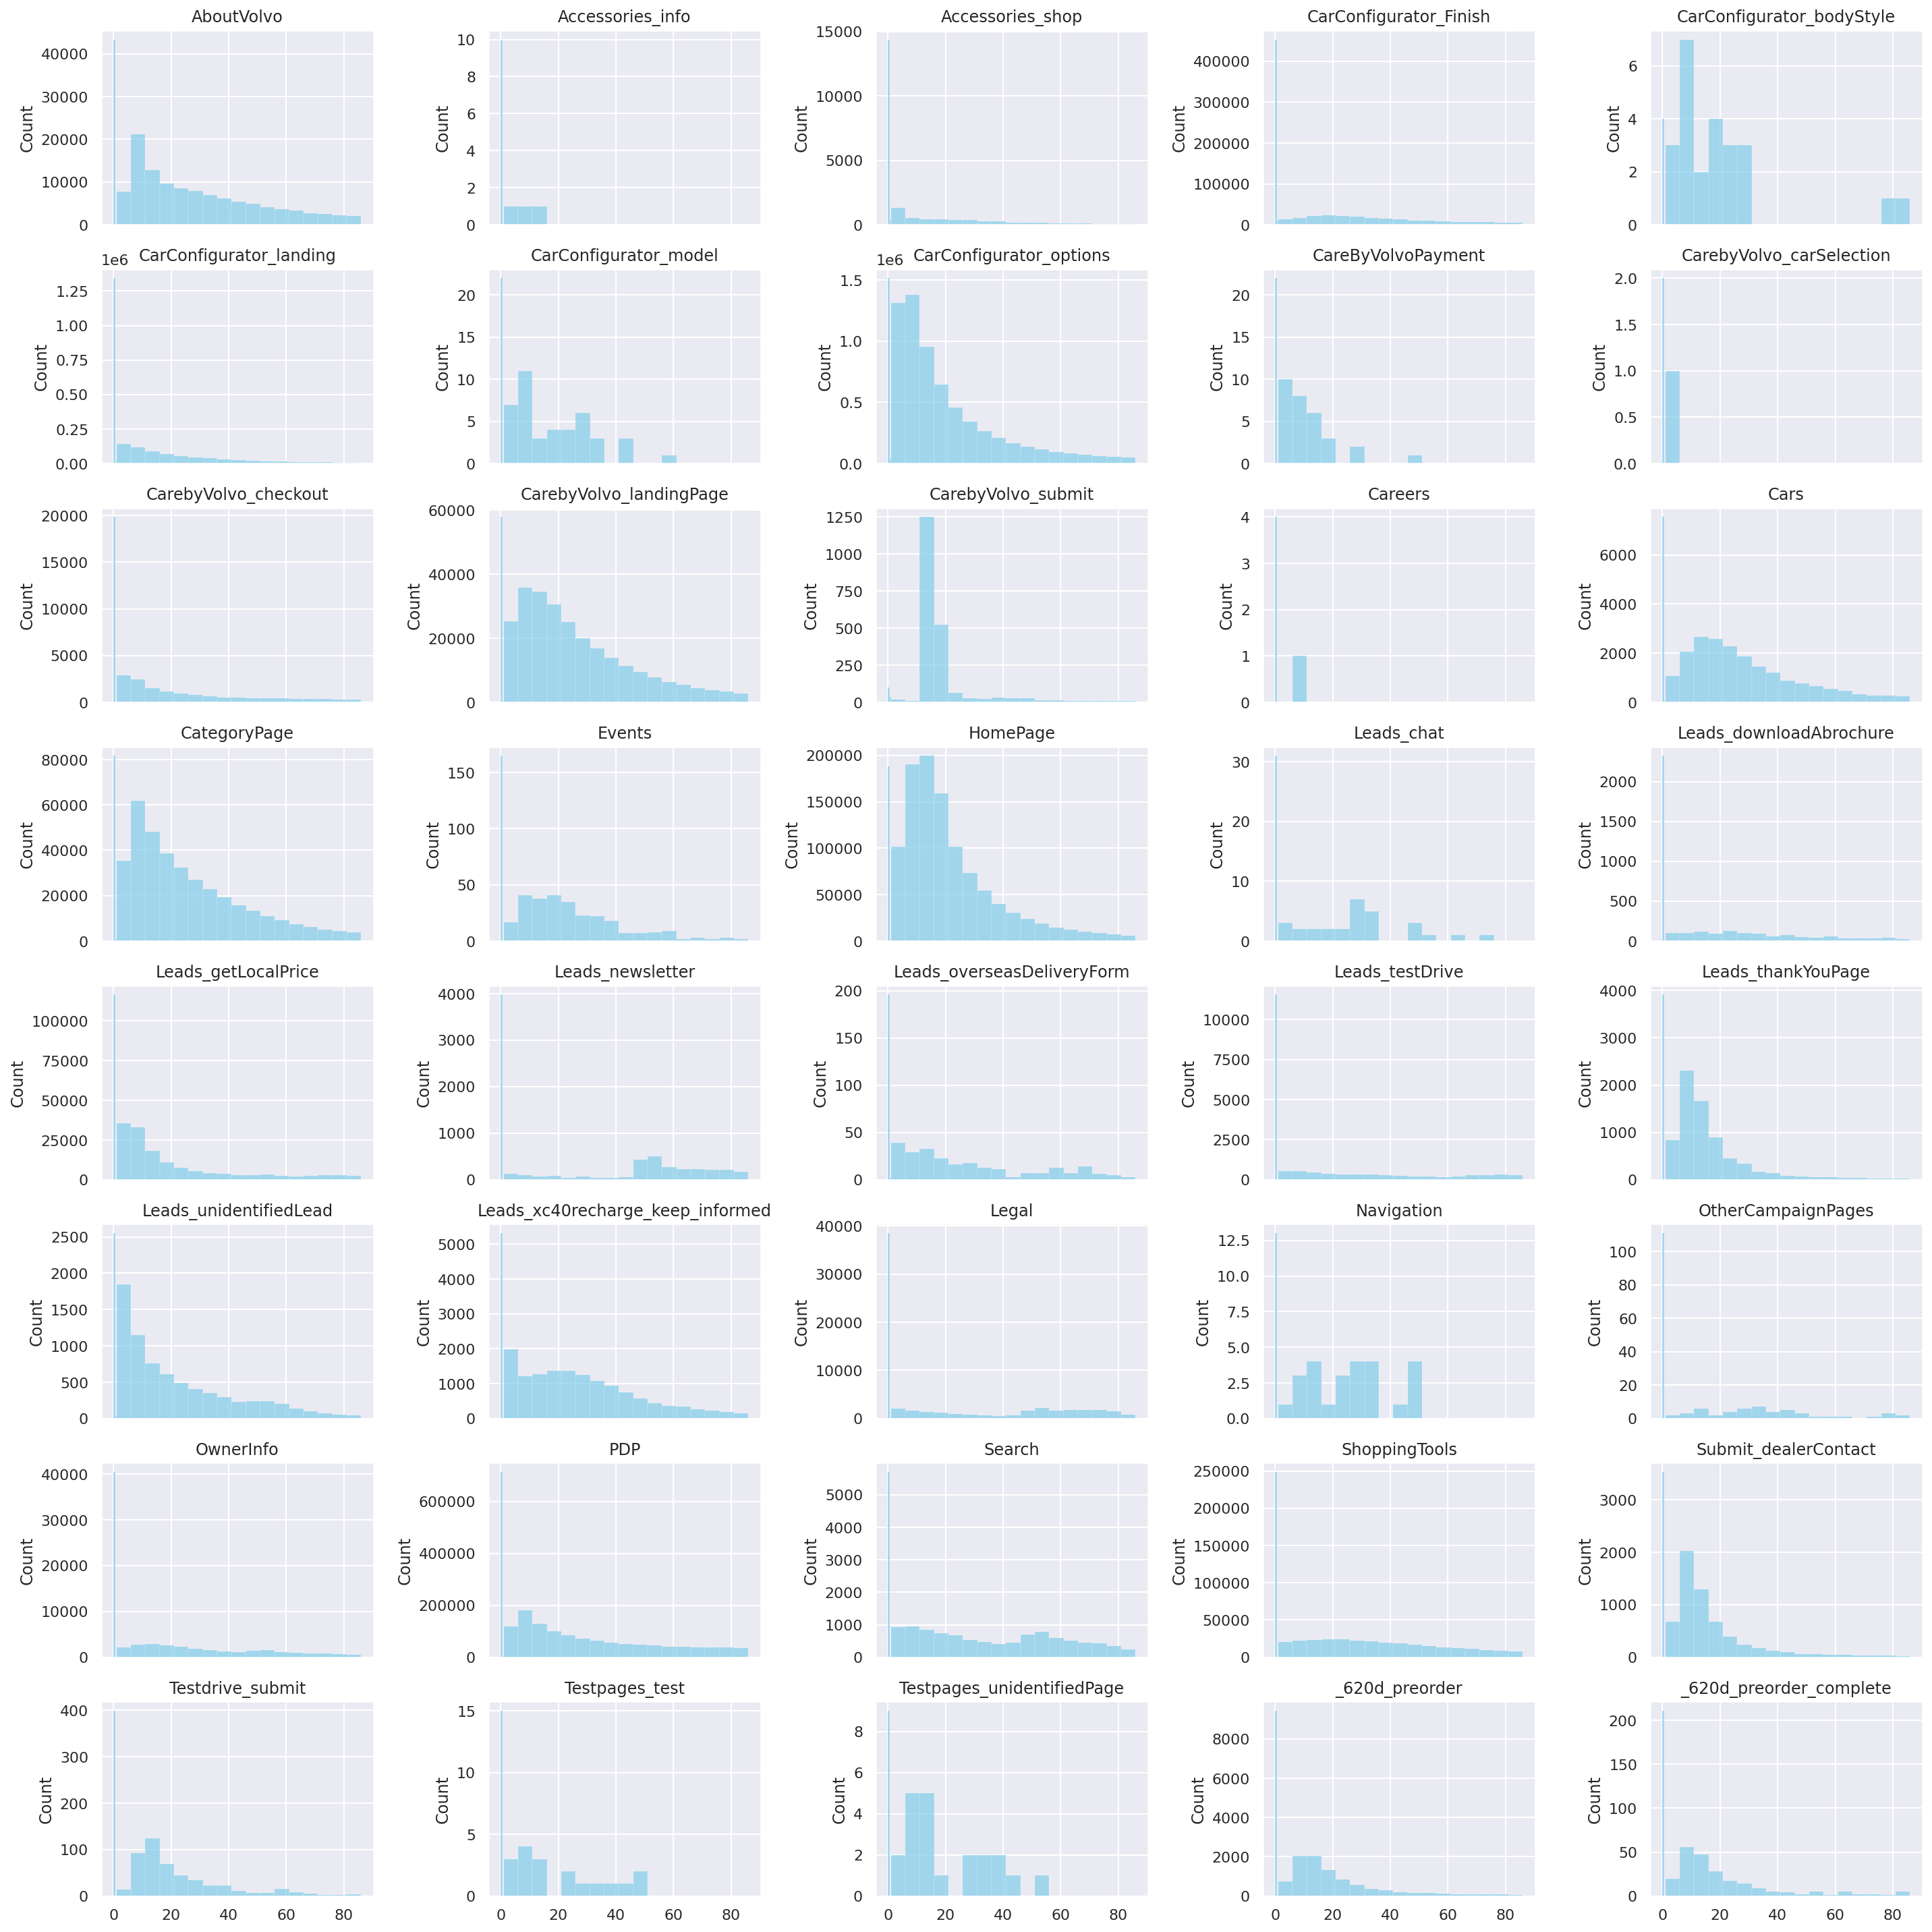

In [ ]:
f, axes = plt.subplots(8, 5, figsize=(20, 20), sharex=True)
for ax, feature in zip(axes.flat, range(40)):
    sns.histplot(groupedtime['timelist'][feature] , color="skyblue", ax=ax, bins = np.append([0, 0.5],np.arange(1, 90, 5)))
    ax.set_title(groupedtime['gen_cat'][feature])
plt.tight_layout()

## Divide each category to three versions by time
- If dwelling time <= 1, we see it as "immediately leave"
- Otherwise, use median to divide it to short/long time

In [ ]:
pd.set_option('display.max_rows', None)
print(groupedtime[['median','median_without_immleave']][:40])

    median  median_without_immleave
0   19.910                   33.270
1    0.020                   12.320
2    0.010                   35.140
3    0.010                   43.880
4   11.640                   16.390
5    0.030                   18.820
6    6.500                   16.860
7   11.070                   15.020
8    4.965                   10.270
9    0.000                    5.800
10   2.450                   36.530
11  19.160                   24.630
12  15.360                   15.500
13   0.000                    9.960
14  20.490                   29.290
15  17.660                   23.420
16  14.380                   24.820
17  15.470                   18.050
18   4.910                   30.110
19   0.000                   80.480
20   4.590                   14.020
21   0.000                   60.260
22  12.705                   40.485
23   0.000                   55.340
24   8.280                   12.750
25   9.650                   17.780
26  17.670                  

### Fun fact: some customers' intention is clear, and it is not to buy a car if they visit "Careers" or "Legal" 

In [ ]:
groupedtime[groupedtime['median'] < 1]

,gen_idx,timelist,median,gen_cat
1,1,"[0.07, 0.0, 0.01, 0.01, 0.02, 0.0, 0.0, 176.87...",0.02,Accessories_info
2,2,"[49.63, 34.0, 41.22, 0.01, 711.56, 19.86, 324....",0.01,Accessories_shop
3,3,"[0.68, 9.67, 0.15, 0.0, 3.43, 39.16, 41.05, 0....",0.01,CarConfigurator_Finish
5,5,"[0.02, 14.46, 0.02, 0.01, 0.0, 0.0, 0.01, 16.2...",0.03,CarConfigurator_landing
9,9,"[5.8, 0.0, 0.0]",0.00,CarebyVolvo_carSelection
13,13,"[0.0, 0.0, 0.0, 9.96, 0.0]",0.00,Careers
19,19,"[7.97, 95.75, 275.38, 53.24, 76.53, 5.89, 57.1...",0.00,Leads_downloadAbrochure
21,21,"[81.64, 1371.85, 22.05, 7.77, 104.48, 56.92, 9...",0.00,Leads_newsletter
23,23,"[0.0, 53.35, 210.77, 706.27, 0.0, 45.77, 93.49...",0.00,Leads_testDrive
27,27,"[1.94, 61.95, 4.46, 0.0, 6.82, 6.06, 32.82, 98...",0.00,Legal


In [ ]:
groupedtime['pct_immleave'] = groupedtime.cnt_immleave / groupedtime.timelist.apply(lambda x: len)

In [ ]:
a = groupedtime.iloc[7].timelist

## Which categories have high immediate leave percentages?
We might want to pay attention those categories with **high imm leave percentage** and also **a large number of imm leave visits**.
- CarConfigurator_landing
- CarConfigurator_Finish
- Accessories_shop
- Leads_testDrive

## What causes immediate leave percentages as high as 60%?
- Talk to/ confirm with backend sde team
    - Did we get our data right? i.e. the way of calculating dwelling time. Why would we have a visit with 0.0 dewelling time?
- Talk to/ confirm with webpage design team
    - Are these immediate leaves come from misclicking? If so, how can we improve our page design?

In [ ]:
groupedtime.sort_values('pct_immleave', ascending=False)[:20]

,gen_idx,timelist,median,cnt_immleave,median_without_immleave,gen_cat,pct_immleave
13,13,"[0.0, 0.0, 0.0, 9.96, 0.0]",0.000,4,9.96,Careers,0.800000
2,2,"[49.63, 34.0, 41.22, 0.01, 711.56, 19.86, 324....",0.010,14738,35.14,Accessories_shop,0.669301
9,9,"[5.8, 0.0, 0.0]",0.000,2,5.80,CarebyVolvo_carSelection,0.666667
1,1,"[0.07, 0.0, 0.01, 0.01, 0.02, 0.0, 0.0, 176.87...",0.020,10,12.32,Accessories_info,0.666667
5,5,"[0.02, 14.46, 0.02, 0.01, 0.0, 0.0, 0.01, 16.2...",0.030,1353135,18.82,CarConfigurator_landing,0.636131
3,3,"[0.68, 9.67, 0.15, 0.0, 3.43, 39.16, 41.05, 0....",0.010,463969,43.88,CarConfigurator_Finish,0.600900
23,23,"[0.0, 53.35, 210.77, 706.27, 0.0, 45.77, 93.49...",0.000,11574,55.34,Leads_testDrive,0.599782
29,29,"[0.0, 0.0, 0.0, 0.0, 636.1, 0.0, 0.0, 0.0, 0.0...",0.000,111,48.61,OtherCampaignPages,0.584211
27,27,"[1.94, 61.95, 4.46, 0.0, 6.82, 6.06, 32.82, 98...",0.000,38523,61.27,Legal,0.556361
21,21,"[81.64, 1371.85, 22.05, 7.77, 104.48, 56.92, 9...",0.000,3986,60.26,Leads_newsletter,0.523647


In [ ]:
gen_dict_withtime = groupedtime.copy()

In [ ]:
gen_dict_withtime.head()

,gen_idx,median,gen_cat
14,14,20.490,Cars
28,28,20.325,Navigation
0,0,19.910,AboutVolvo
31,31,19.380,PDP
11,11,19.160,CarebyVolvo_landingPage




## Current Indexing Approach
- Split to three category indexes: x, x+100, x+200
  - E.g. If a customer spent short time on "AboutVolvo", its category is 0 (same as gen_idx); if he/she spent long time (greater than median), its category is 100 (= 0 + 100); if he/she immediately leaves (spent less than 1 sec), its category is 200 (= 0 + 200). 
  - It won't contradict with other categories because there are fewer than 100 general categories.


In [ ]:
gen_dict_withtime['gen_idx_long'] = gen_dict_withtime.apply(lambda x: x['gen_idx'] + 100, axis = 1)
gen_dict_withtime['gen_idx_immleave'] = gen_dict_withtime.apply(lambda x: x['gen_idx'] + 200, axis = 1)

In [ ]:
gen_dict_withtime = gen_dict_withtime[['gen_idx', 'median', 'median_without_immleave', 'gen_cat','gen_idx_long','gen_idx_immleave']]

In [ ]:
gen_dict_withtime.to_csv('./Datasets/gen_dict_withtime.csv', index=False)

In [ ]:
gen_dict_withtime.head()

,gen_idx,median,median_without_immleave,gen_cat,gen_idx_long,gen_idx_immleave
0,0,19.91,33.27,AboutVolvo,100,200
1,1,0.02,12.32,Accessories_info,101,201
2,2,0.01,35.14,Accessories_shop,102,202
3,3,0.01,43.88,CarConfigurator_Finish,103,203
4,4,11.64,16.39,CarConfigurator_bodyStyle,104,204
